## Multivariate_multi_forecast

In [ ]:
!rm -rf sample_data

In [ ]:
from market import EquityData
from models.lstm import split, split_multivariate, show_plot, create_time_steps
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from utils import plot_train_history, multi_step_plot
from technical_analysis import moving_average

tf.random.set_seed(42)

BATCH_SIZE = 128
BUFFER_SIZE = 10000
EPOCHS = 15
step = 1
history_size = 30
target_distance = 1

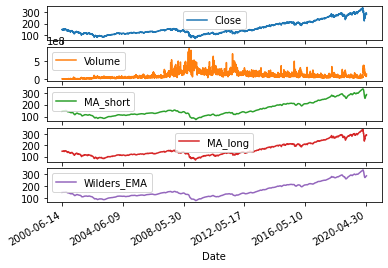

In [ ]:
features_considered = ['Close', 'Volume', 'MA_short', 'MA_long', 'Wilders_EMA']
e = EquityData('SPY.csv', 'SPY')
e.data['MA_short'] = moving_average(e, window=21)
e.data['MA_long'] = moving_average(e, window=5)
e.data['Wilders_EMA'] = e.close().ewm(alpha=1/15, adjust=False).mean()
e.data = e.data[21:]
EVALUATION_INTERVAL = int(e.data.shape[0]/BATCH_SIZE) * 1
features = e.data[features_considered]
assert(list(features)[0] == 'Close')
features.index = e.date()

features.plot(subplots=True)
plt.show()

In [ ]:
dataset = features.values
x_train_multi, y_train_multi, x_val_multi, y_val_multi = split_multivariate(dataset, history_size, target_distance, step, single_step=False)


print('Single window of past history: {}'.format(x_train_multi[0].shape))
print('\n Target temperature to predict: {}'.format(y_train_multi[0].shape))

Single window of past history: (30, 5)

 Target temperature to predict: (1,)


In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()


val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(16,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(4, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(target_distance))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')


In [ ]:
val_callback = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/multivariate_multi_model', monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch'
)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50, callbacks=[val_callback])


Epoch 1/15
38/39 [============================>.] - ETA: 0s - loss: 0.3872WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: checkpoints/multivariate_multi_model/assets
39/39 [==============================] - 8s 198ms/step - loss: 0.3809 - val_loss: 2.6636
Epoch 2/15
39/39 [==============================] - 7s 182ms/step - loss: 0.1233 - val_loss: 1.8076
Epoch 3/15
39/39 [==============================] - 7s 184ms/step - loss: 0.1084 - val_loss: 1.7572
Epoch 4/15
39/39 [==============================] - 7s 184ms/step - loss: 0.1040 - val

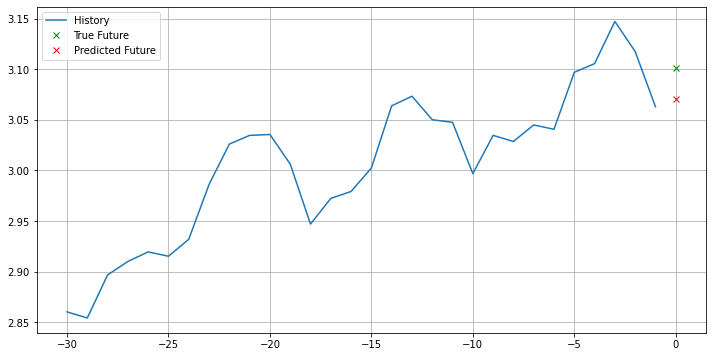

INFO:tensorflow:Assets written to: save_models/multivariate_multi_model/assets


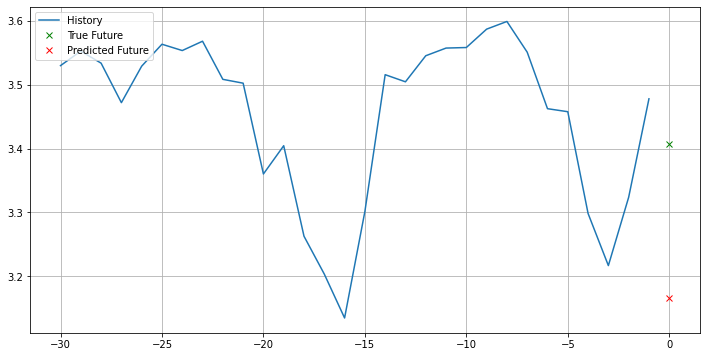

INFO:tensorflow:Assets written to: save_models/multivariate_multi_model/assets


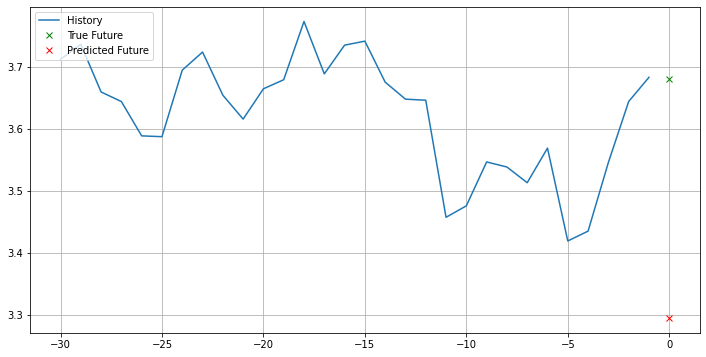

INFO:tensorflow:Assets written to: save_models/multivariate_multi_model/assets


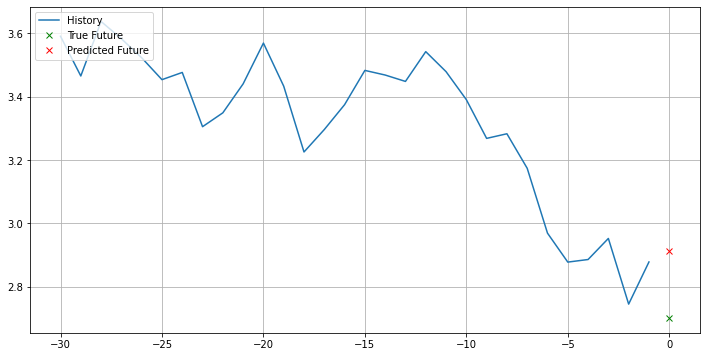

INFO:tensorflow:Assets written to: save_models/multivariate_multi_model/assets


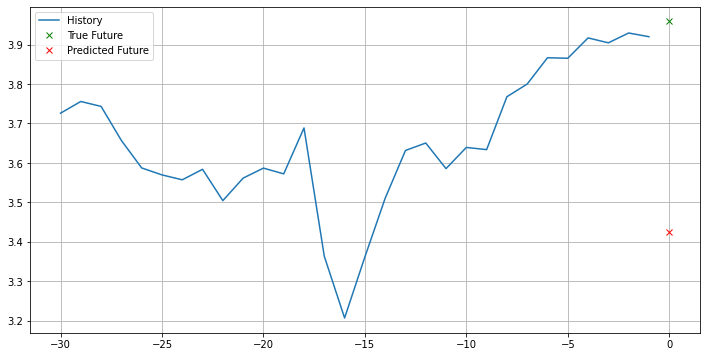

INFO:tensorflow:Assets written to: save_models/multivariate_multi_model/assets


In [ ]:
# plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

for x, y in val_data_multi.take(5):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0], step).show()

  multi_step_model.save('save_models/multivariate_multi_model')

## Multivariate single forecast

In [ ]:
from market import EquityData
from models.lstm import split, split_multivariate, show_plot
import matplotlib.pyplot as plt
import tensorflow as tf 
from utils import plot_train_history
from technical_analysis import moving_average

import pandas as pd


In [ ]:
import pandas as pd
from ta.utils import dropna
from ta.volatility import BollingerBands
#from ta import add_all_ta_features


In [ ]:

BATCH_SIZE = 128 
BUFFER_SIZE = 10000
EPOCHS = 10
CLASSIFICATION = True 

step = 1
history_size = 180
target_distance = 6

In [ ]:
features_considered = ['Close', 'Volume', 'MA_short', 'MA_long', 'Wilders_EMA', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_bbhi', 'bb_bbli']
features_considered = ['Close', 'Volume', 'Wilders_EMA', 'bb_bbm', 'bb_bbh', 'bb_bbl',
                       'bb_bbhi', 'bb_bbli', 'trend_adx', 'momentum_stoch_signal', 
                       'trend_trix', 'trend_ichimoku_a', 'momentum_kama', 'momentum_tsi', 
                       'volatility_kcli']
features_considered = ['close', 'MA_long', 'MA_short']

In [ ]:
{0}/currencies/oanda/{1}/{2}/*.csv'.forma
/content/financial-data/pyfinancialdata/data/currencies

In [ ]:
import pandas as pd
import os
import glob

data_dir = 'SPY.csv'

def get(provider, instrument, year, price_calculation='close', time_group=None, drop_non_price_columns=False):
  
    if provider == 'oanda':
        price_data = pd.DataFrame()
        csv_files = glob.glob('/content/financial-data/pyfinancialdata/data/currencies/oanda/{1}/{2}/*.csv'.format(data_dir, instrument, year))
        for csv_file in csv_files:
            price_data = price_data.append(pd.read_csv(csv_file, index_col=0))

    elif provider == 'kraken':
        filename = '/content/financial-data/pyfinancialdata/data/cryptocurrencies/kraken/{1}/{2}.csv'.format(data_dir, instrument, year)
        price_data = pd.read_csv(filename, index_col=0)

    elif provider == 'bitstamp':
        filename = '/content/financial-data/pyfinancialdata/data/cryptocurrencies/bitstamp/{1}/{2}.csv'.format(data_dir, instrument, year)
        price_data = pd.read_csv(filename, index_col=0)

    elif provider == 'histdata':
        filename = '/content/financial-data/pyfinancialdata/data/stocks/histdata/{1}/DAT_ASCII_{1}_M1_{2}.csv'.format(data_dir, instrument, year)
        price_data = pd.read_csv(filename, index_col=0, delimiter=';', header=None)
        price_data.drop(columns=[5], inplace=True)
        columns={1: 'open', 2: 'high', 3: 'low', 4: 'close'}
        price_data.rename(columns=columns, inplace=True)

    else:
        raise Exception('Unkown provider {0}'.format(provider))

    '''
    Set the index and sort out the index
    '''
    price_data.index.name = 'date'
    price_data.index = pd.to_datetime(price_data.index)
    # Sort by index
    price_data.sort_index(inplace=True)
    # Remove duplicate index rows
    price_data = price_data[~price_data.index.duplicated(keep='first')]

    '''
    Optional timegrouping for larger timeframes
    '''
    if time_group:
        grouped_data = pd.DataFrame({
            'close': price_data.groupby(pd.Grouper(freq=time_group)).close.last(),
            'high': price_data.groupby(pd.Grouper(freq=time_group)).high.max(),
            'low': price_data.groupby(pd.Grouper(freq=time_group)).low.min(),
            'open': price_data.groupby(pd.Grouper(freq=time_group)).open.first(),
        })
        price_data = grouped_data

    '''
    Calculate a price column if required
    '''
    if price_calculation:
        if price_calculation == '4by4':
            price_data['price'] = (price_data['open'] + price_data['high'] + price_data['low'] + price_data['close']) / 4
        elif price_calculation == 'open':
            price_data['price'] = price_data['open']
        elif price_calculation == 'close':
            price_data['price'] = price_data['close']
        price_data = price_data.dropna(subset=['price'])


    '''
    Drop all columns except for price if required
    '''
    if drop_non_price_columns:
        for col in list(price_data.columns):
            if col != 'price':
                del price_data[col]

    return price_data

def get_multi_year(provider, instrument, years, time_group):
  year_dfs = []

  for year in years:
    year_dfs.append(
        get(
            provider = provider, 
            instrument = instrument,
            year = year, 
            time_group = time_group
        )
    )

  # Concatenate the dataframes
  price_data = pd.concat(year_dfs)
  # Sort by index 
  price_data.sort_index(inplace = True)

  # Deduplicate just in case
  price_data = price_data[~price_data.index.duplicated(keep='first')]
  # Remove any missing data
  price_data.dropna(axis=0, inplace=True)

  return price_data

In [ ]:
!pip install https://github.com/FutureSharks/financial-data/archive/master.zip

In [ ]:
!git clone https://github.com/FutureSharks/financial-data.git

Cloning into 'financial-data'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 5146 (delta 2), reused 4 (delta 0), pack-reused 5133
Receiving objects: 100% (5146/5146), 824.90 MiB | 16.95 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Checking out files: 100% (4632/4632), done.


In [ ]:
!unzip financial-data-master.zip


unzip:  cannot find or open financial-data-master.zip, financial-data-master.zip.zip or financial-data-master.zip.ZIP.


In [ ]:
# Initialize Bollinger Bands Indicator

e = EquityData('SPY.csv', 'SPY')
data = get_multi_year(provider='histdata', instrument='SPXUSD', years=[2016, 2017, 2018], time_group='10min')
e.data = data


In [ ]:
e.data.head(2)

,close,high,low,open,price
date,,,,,
2016-01-03 18:00:00,2041.75,2043.0,2037.75,2037.75,2041.75
2016-01-03 18:10:00,2041.75,2042.0,2040.75,2042.00,2041.75


In [ ]:
pip install -U scikit-learn


     |████████████████████████████████| 6.8MB 13.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
e.data['MA_long'] = e.data['close'].rolling(window=52).mean()
e.data['MA_short'] = e.data['close'].rolling(window=7).mean()

In [ ]:
#indicator_bb = BollingerBands(close=e.data['close'], n=20, ndev=2)

print(list(e.data))

['close', 'high', 'low', 'open', 'price', 'MA_long', 'MA_short']


In [ ]:
EVALUATION_INTERVAL = int(e.data.shape[0]/BATCH_SIZE) * 1
features = e.data[features_considered]
features.index = e.data.index
# assert(list(features)[0] == 'Close')
features = features.dropna()
features = features[26:]


In [ ]:
dataset = features.values
x_train_single, y_train_single, x_val_single, y_val_single = split_multivariate(dataset, history_size, target_distance,
                                                                                step, single_step=True, classification=CLASSIFICATION)


In [ ]:
print('Single window of past history : {}'.format(x_train_single[0].shape))


Single window of past history : (180, 3)


In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices(
    (x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [ ]:
val_data_single = tf.data.Dataset.from_tensor_slices(
    (x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True,
                                           input_shape=x_train_single.shape[-2:]))
# single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))

single_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
if CLASSIFICATION:
  single_step_model.add(tf.keras.layers.Dense(16, activation='relu'))
  single_step_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
else:
  single_step_model.add(tf.keras.layers.Dense(1))


Epoch 1/10
809/809 [==============================] - ETA: 0s - loss: 0.6877 - accuracy: 0.5514
Epoch 00001: val_accuracy improved from -inf to 0.54937, saving model to checkpoints/multivariate_single_model
INFO:tensorflow:Assets written to: checkpoints/multivariate_single_model/assets
809/809 [==============================] - 216s 267ms/step - loss: 0.6877 - accuracy: 0.5514 - val_loss: 0.6913 - val_accuracy: 0.5494
Epoch 2/10
809/809 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.5578
Epoch 00002: val_accuracy did not improve from 0.54937
809/809 [==============================] - 211s 260ms/step - loss: 0.6862 - accuracy: 0.5578 - val_loss: 0.6921 - val_accuracy: 0.5494
Epoch 3/10
809/809 [==============================] - ETA: 0s - loss: 0.6871 - accuracy: 0.5527
Epoch 00003: val_accuracy did not improve from 0.54937
809/809 [==============================] - 210s 259ms/step - loss: 0.6871 - accuracy: 0.5527 - val_loss: 0.6884 - val_accuracy: 0.5494
Epoch 

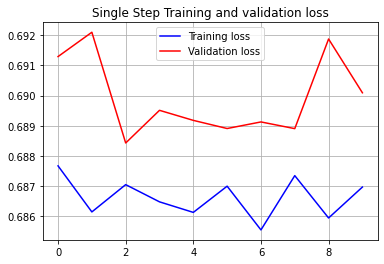

prediction: [0.5788991]


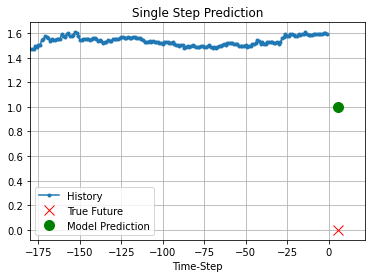

prediction: [0.5791734]


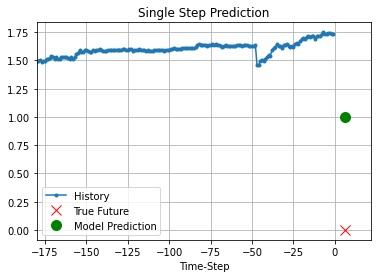

prediction: [0.57936054]


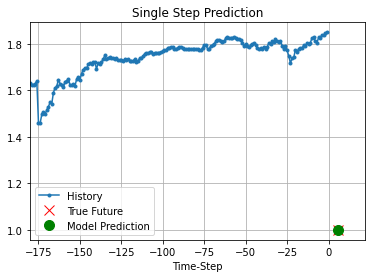

prediction: [0.57954556]


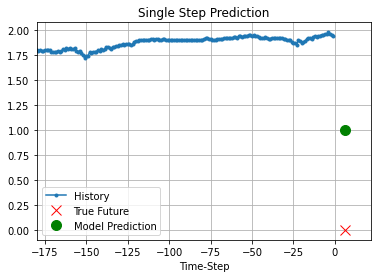

prediction: [0.57942295]


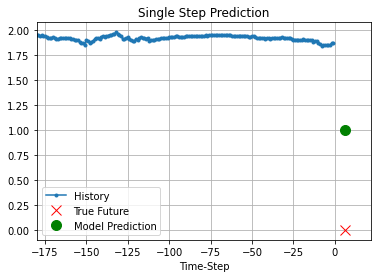

prediction: [0.5794511]


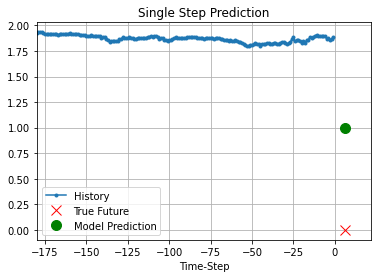

prediction: [0.57945496]


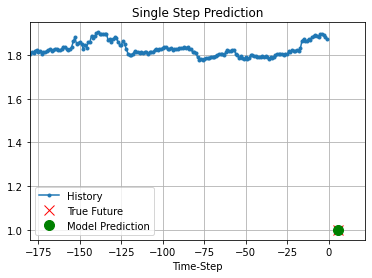

prediction: [0.5793277]


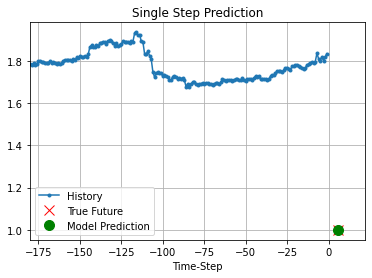

prediction: [0.57939285]


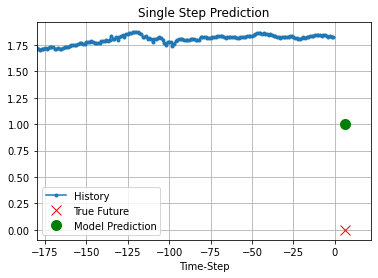

prediction: [0.57961315]


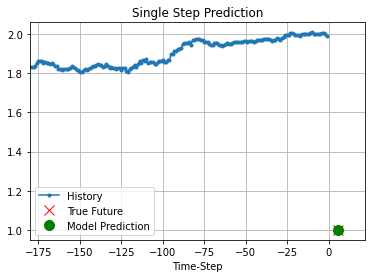

In [ ]:
# single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

val_callback = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/multivariate_single_model', monitor='val_accuracy', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch'
)

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50, callbacks=[val_callback])


plot_train_history(single_step_history,
                   'Single Step Training and validation loss')


for x, y in val_data_single.take(10):
  y_pred = single_step_model.predict(x)[0]
  print(f"prediction: {y_pred}")
  if CLASSIFICATION:
    if y_pred >= 0.5:
      y_pred = 1
    else:
      y_pred = 0
  plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    y_pred], target_distance,
                   'Single Step Prediction')
  plot.show()

In [ ]:
# step 1: Create zip file 
!zip -r /content/file.zip /content/Folder_To_Zip

# step 2: Download 

from google.colab import files
files.download("/content/file.zip")

## Univariate forecast

In [ ]:
from market import EquityData
from models.lstm import split, show_plot
import tensorflow as tf

tf.random.set_seed(42)

BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [ ]:
e = EquityData('SPY.csv', 'SPY')
x_train_uni, y_train_uni, x_val_uni, y_val_uni = split(e)

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])


In [ ]:
simple_lstm_model.compile(optimizer='adam', loss='mae')

for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 0.3164 - val_loss: 3.2091
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1001 - val_loss: 2.5751
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0766 - val_loss: 2.3107
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0720 - val_loss: 2.2474
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0698 - val_loss: 2.2132
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0685 - val_loss: 2.1811
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0671 - val_loss: 2.1420
Epoch 8/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0661 - val_loss: 2.0999
Epoch 9/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0652 - val_loss: 2.0641
Epoch 10/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0645 - val_loss: 2.0343

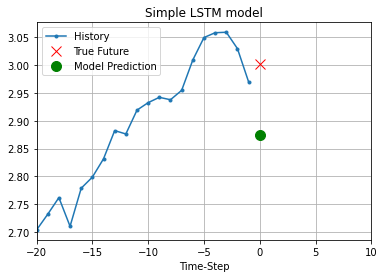

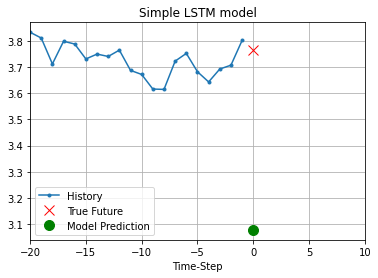

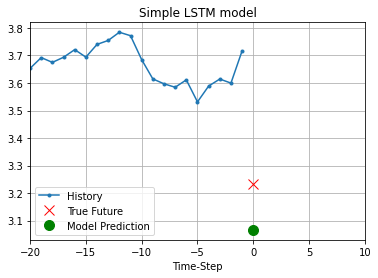

In [ ]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

## Validate multivariate multi

In [ ]:
from market import EquityData
from models.lstm import split, split_multivariate, show_plot, create_time_steps
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from utils import plot_train_history, multi_step_plot
from technical_analysis import moving_average

In [ ]:
BATCH_SIZE = 128 
BUFFER_SIZE = 10000

tf.random.set_seed(42)

step = 1
history_size = 30
target_distance = 1


In [ ]:
features_considered = ['Close', 'Volume', 'MA_short', 'MA_long']
e = EquityData('SPY.csv', 'SPY')
e.data['MA_short'] = moving_average(e, window = 21)
e.data['MA_long'] = moving_average(e, window=5)
e.data = e.data[21:]

EVALUATION_INTERNAL = int(e.data.shape[0]/BATCH_SIZE) * 1
features = e.data[features_considered]
assert(list(features)[0]=='Close')
features.index = e.date()

In [ ]:
dataset = features.values
x_train_multi, y_train_multi, x_val_multi, y_val_multi = split_multivariate(dataset, history_size, target_distance, step, single_step=False)
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (30, 4)

 Target temperature to predict : (1,)


In [ ]:

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

## Validate multivariate single

In [ ]:
from market import EquityData
from models.lstm import split, split_multivariate, show_plot
import matplotlib.pyplot as plt
import tensorflow as tf
from utils import plot_train_history

from ta.volatility import BollingerBands


import pandas as pd
from ta.utils import dropna
from ta.volatility import BollingerBands


tf.random.set_seed(42)

BATCH_SIZE = 128
BUFFER_SIZE = 10000
EPOCHS = 10
CLASSIFICATION = True

step = 1
history_size = 21
target_distance = 2

In [ ]:
features_considered = ['Close', 'Volume', 'MA_short', 'MA_long', 'Wilders_EMA', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_bbhi', 'bb_bbli']
# features_considered = ['Close', 'MA_short', 'MA_long', 'Wilders_EMA']
# Initialize Bollinger Bands Indicator
e = EquityData('SPY.csv', 'SPY')
indicator_bb = BollingerBands(close=e.close(), window = 20, window_dev=2)
e.data['MA_short'] = moving_average(e, window=history_size)
e.data['MA_long'] = moving_average(e, window=5)
e.data['Wilders_EMA'] = e.close().ewm(alpha=1/history_size, adjust=False).mean()


In [ ]:
pip install -U scikit-learn


     |████████████████████████████████| 6.8MB 7.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
#from sklearn.cross_validation import ShuffleSplit
#from sklearn.cross_validation import train_test_split
indicator_bb = BollingerBands(close=e.close(), window = 20, window_dev = 2)

In [ ]:
# Add Bollinger Bands features
e.data['bb_bbm'] = indicator_bb.bollinger_mavg()
e.data['bb_bbh'] = indicator_bb.bollinger_hband()
e.data['bb_bbl'] = indicator_bb.bollinger_lband()
# Add Bollinger Band high indicator
e.data['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()
# Add Bollinger Band low indicator
e.data['bb_bbli'] = indicator_bb.bollinger_lband_indicator()
e.data = e.data[21:]


In [ ]:
EVALUATION_INTERVAL = int(e.data.shape[0]/BATCH_SIZE) * 2
features = e.data[features_considered]
assert(list(features)[0] == 'Close')
features.index = e.date()

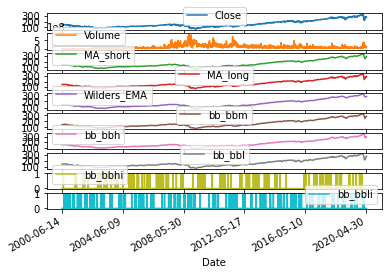

In [ ]:
features.plot(subplots = True)
plt.show()

In [ ]:
# step 1: Create zip file 
!zip -r /content/file.zip /content/Folder_To_Zip

# step 2: Download 

from google.colab import files
files.download("/content/file.zip")

In [ ]:
/content/checkpoints

In [ ]:
!zip -r /content/financial-data.zip/content/Folder_To_zip

/content/checkpoints
/content/financial-data
/content/models
/content/save_models


In [ ]:
!zip -r /content/financial-data.zip /content/financial-data_To_Zip


	zip warning: name not matched: /content/financial-data_To_Zip

zip error: Nothing to do! (try: zip -r /content/financial-data.zip . -i /content/financial-data_To_Zip)


In [ ]:
extension_zip = ".zip"
filename = '/content/financial-data'
zip_file = filename + extension_zip

# !rm -rf $zip_file
!zip -r $zip_file {folders_or_files_to_save}


zip error: Nothing to do! ({folders_or_files_to_save}.zip)


In [ ]:
import shutil
shutil.make_archive('/content/financial-data', 'zip', '/content/financial-data')


'/content/financial-data.zip'

In [ ]:
import shutil
shutil.make_archive('/content/same_models', 'zip', '/content/financial-da')

In [122]:
from google.colab import files
files.download("/content/financial-data.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [123]:
from google.colab import files
files.download("/content/save_models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>